# Import and misc

In [1]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [2]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 30
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [3]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-11-06 15:53:52--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.4.128, 2404:6800:4003:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.4.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   153MB/s    in 8.1s    

2022-11-06 15:54:00 (176 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [4]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [5]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [6]:
dataset.csv.sample(5)

,path,keyword,label
6363,speech_commands/yes/e7ea8b76_nohash_0.wav,yes,0
6941,speech_commands/yes/57b38f48_nohash_0.wav,yes,0
51517,speech_commands/up/5b09db89_nohash_0.wav,up,0
39835,speech_commands/down/74551073_nohash_0.wav,down,0
8632,speech_commands/wow/512dc91a_nohash_0.wav,wow,0


### Augmentations

In [7]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [8]:
torch.manual_seed(9999)
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [9]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [10]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [11]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [12]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [13]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [14]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [15]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [16]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [17]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [18]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [19]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [20]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [21]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

# Training

In [22]:
import random

def set_seed(seed=3407):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [23]:
set_seed()

config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

### HomeWork_0

Для ДЗ бейзлайн обучался чуть дольше, а именно 30 эпох, это должно будет помочь при дистиляции моделей, ибо чем лучше учитель, тем лучше должна работать дистиляция.

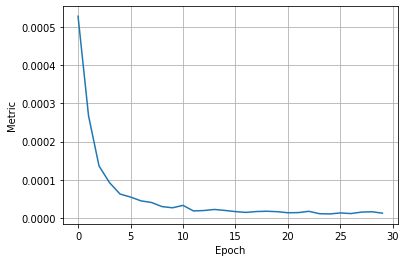

END OF EPOCH 29 LAST METRIC 1.2179764613069435e-05


In [ ]:
# TRAIN

history = defaultdict(list)
for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n, 'LAST METRIC', history['val_metric'][-1])

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.000528497948879302,
              0.0002675490282520113,
              0.00013577662633947198,
              9.221054522349286e-05,
              6.225942391384294e-05,
              5.445387167773573e-05,
              4.4374683813221134e-05,
              4.0149660125786944e-05,
              2.937226919428112e-05,
              2.6251241809354458e-05,
              3.256490715018124e-05,
              1.798022086191975e-05,
              1.9090184712008393e-05,
              2.1823321504162144e-05,
              1.9281146234604287e-05,
              1.6261567158556694e-05,
              1.416695795758297e-05,
              1.6434626038409225e-05,
              1.717460193846832e-05,
              1.6028832802892948e-05,
              1.3230052987346861e-05,
              1.367761905593099e-05,
              1.6983640415872425e-05,
              1.0741585646019101e-05,
              1.018660372097478e-05,
              1.275861672843824

In [24]:
# torch.save(model.state_dict(), 'checkpoints/baseline.pth')
model.load_state_dict(torch.load('checkpoints/baseline.pth'))

<All keys matched successfully>

# HomeWork

## Streaming

Начнём нашу ДЗ с реализации стриминга, она будет работать примерно следующим образом:

1.   На вход нашей модели приходит чанк звука (любой длины)
2.   Мы начинаем ездить по этому чанку окном размера `max_window_length` и с шагом `streaming_step_size`
3.   Для каждого окна считается вероятность ключевого слоя на основе CRNN модели, между окнами пробрасывается `gru_hidden_state`
4.   Необработанный остаток чанка, который не поместился в последнее окно сохраняется для обработки со следующим чанком
5.   Модель возвращает либо максимум вероятностей из всех окон, либо вероятности для каждого окна (это понадобится для красивых графиков)

Немного отчёта: я пробовал разные реализации стриминга и разные фичи, например, пытался сбрасывать состояние стриминга (обнуление hidden_state), после того, как модель перестала с определённым порогом детектить ключевое слово, но лучший на мой взгляд результат показала обычная модель без дополнительных эвристик.

In [25]:
from copy import deepcopy

class StreamingCRNN(nn.Module):
    def __init__(self, model, config, max_window_length=100, streaming_step_size=1):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            )
        self.model = deepcopy(model).eval().cpu()
        self.max_window_length = max_window_length
        self.streaming_step_size = streaming_step_size
        self.bidirectional = 2 if config.bidirectional else 1
        self.gru_num_layers = config.gru_num_layers
        self.hidden_size = config.hidden_size
        
        self.register_buffer('hidden_state', torch.tensor([]))
        self.register_buffer('remains', torch.tensor([]))
        self.reset()
        
    def reset(self):
        self.hidden_state = torch.zeros(self.bidirectional * self.gru_num_layers, 1, self.hidden_size)
        self.remains = torch.zeros(0)
        
    def set_max_window_length(self, val):
        self.max_window_length = val
    
    def set_streaming_step_size(self, val):
        self.streaming_step_size = val
    
    def forward(self, input, reduce=True):
        melspec = torch.log(self.melspec(input).clamp_(min=1e-9, max=1e9))
        melspec = torch.cat((self.remains, melspec), dim=-1)
        self.remains = torch.zeros(0)
        
        preds = torch.tensor([0])
        while melspec.size(-1) >= self.max_window_length:
            input = melspec[:, :, :self.max_window_length].unsqueeze(dim=1)
            melspec = melspec[:, :, self.streaming_step_size:]
            
            conv_output = self.model.conv(input).transpose(-1, -2)
            gru_output, self.hidden_state = self.model.gru(conv_output, self.hidden_state)
            contex_vector = self.model.attention(gru_output)
            output = self.model.classifier(contex_vector)
            probs = F.softmax(output, dim=-1)
            preds = torch.cat((preds, probs[:, -1]))
        
        if melspec.size(-1) > 0:
            self.remains = melspec
        
        if reduce:
            return preds.max()
        else:
            return preds[1:]

Теперь напишем код, который будет случайным образом из валидации выбирать записи с нашим ключевым словом и без и объединим их в одну запись, этот автоматизированный код понадобится нам дальше для подбора гиперпараметров стриминга.

In [26]:
set_seed(137)
stream_melspec = LogMelspec(is_train=False, config=TaskConfig)
stream_melspec.melspec.cpu()

positive = np.random.choice(val_set.csv[val_set.csv.label == 1].index.values, size=2, replace=False).tolist()
negative = np.random.choice(val_set.csv[val_set.csv.label == 0].index.values, size=15, replace=False).tolist()

samples = negative[:5] + [positive[0]] + negative[5:10] + [positive[1]] + negative[10:]

sample_wavs = []
sample_labels = []
sample_idx = []
glob_len = 0

for idx in samples:
    wav = val_set[idx]['wav'].view(1, -1)
    label = val_set[idx]['label']
    len_wav = stream_melspec(wav).size(-1) - 1

    sample_wavs.append(wav)
    sample_labels.append(label)
    sample_idx.append([glob_len, glob_len + len_wav])
    glob_len += len_wav

cat_wav = torch.cat(sample_wavs, dim=-1)

Теперь инициализируем нашу стриминговую модель на основе предобученной CRNN и напишем функцию, которая будет строить нам графики для различных гиперпараметров.

In [27]:
stream_config = TaskConfig(hidden_size=32, device='cpu')
stream_model = StreamingCRNN(model, stream_config).eval()

In [28]:
def plot_streaming_configs(stream_model, win_lens, steps):
    for win_len, step in zip(win_lens, steps):
        stream_model.reset()
        stream_model.set_max_window_length(win_len)
        stream_model.set_streaming_step_size(step)

        with torch.inference_mode():
            predict = stream_model(cat_wav, reduce=False)
        
        # We do processing for each frame
        predict = predict.view(-1, 1).expand(-1, step).reshape(-1)
        pad = torch.Tensor([predict[-1]] * (glob_len - predict.shape[0]))
        predict = torch.cat((predict, pad))

        fig, ax = plt.subplots(figsize=(16, 8))
        ax.plot(predict, label='probability')
        ax.set_title(f'Probability over time, window_length={win_len}, step_size={step}')
        ax.set_xlabel('Frame')
        ax.set_ylabel('Keyword probability')

        pos_cnt = 0
        for i in range(len(sample_labels)):
            if sample_labels[i]:
                pos_cnt += 1
                start, end = sample_idx[i]
                ax.vlines(start, 0, 1, color='green', linestyles='dashed', label=f'positive sample {pos_cnt}')
                ax.vlines(end, 0, 1, color='green', linestyles='dashed')


        plt.legend()
        plt.grid()
        plt.show()

Построим немного графиков с разными window_length, беря единичный шаг.

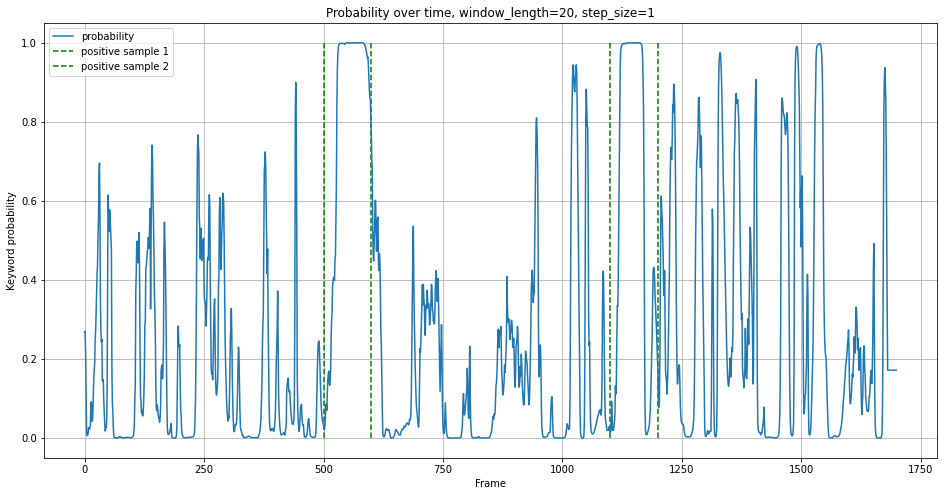

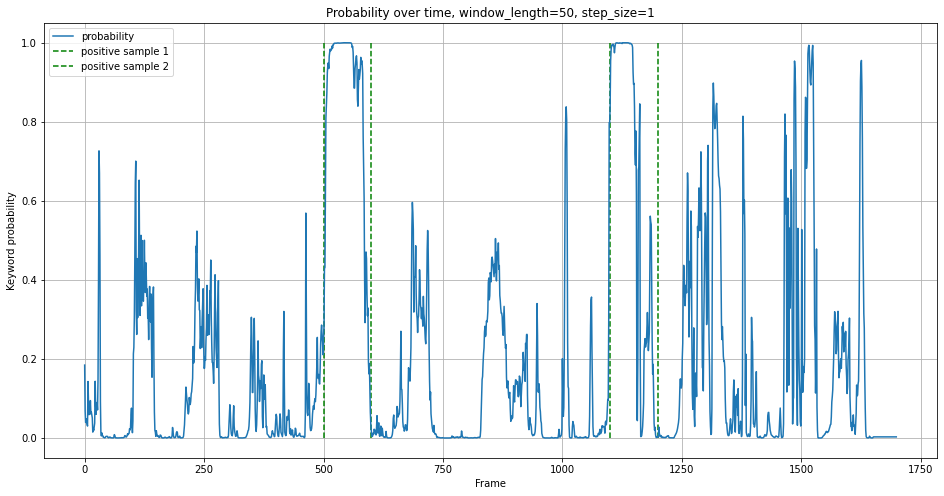

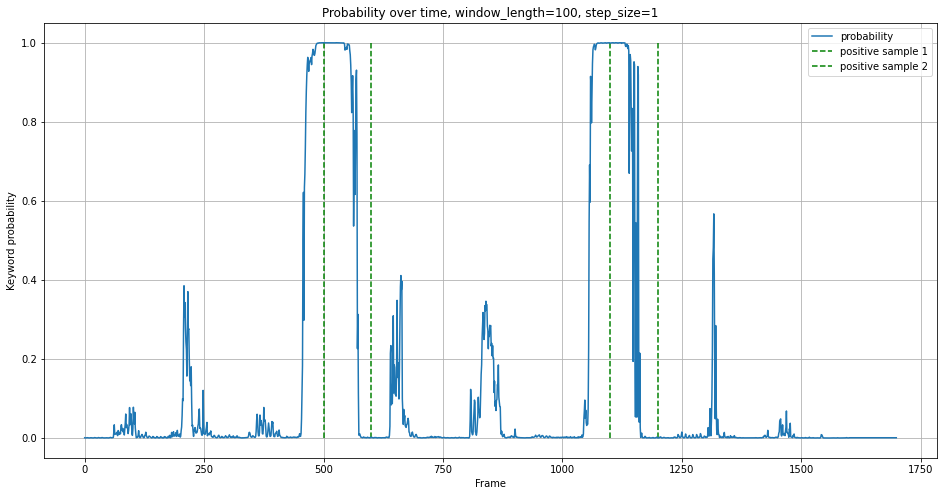

In [29]:
plot_streaming_configs(stream_model, [20, 50, 100], [1, 1, 1])

Как мы можем наблюдать, если брать окно слишком маленького размера, то график вероятностей получается достаточно шумным и увеличение его размера это одна из регуляризаций убирать FP (False Positive) примеры. Но при этом, если брать window_length слишком большим, то видим, что модель определяет наши positive примеры немного раньше, это связано с тем, что окно большого размера задевает окончанием ключевое слово и начинает его детектить, а значит, наша модель смотрит немного в будущее, но с запазданием в режиме стриминга, понятно, что это опоздание ограничено сверху window_length. Поэтому нужно брать окно такого размера, чтобы мы достаточно своевременно в стриминге делали предикт, но при этом избегали слишком большого количества FP из-за маленького окна.

Теперь проведём ещё несколько экспериментов со step_size и window_length

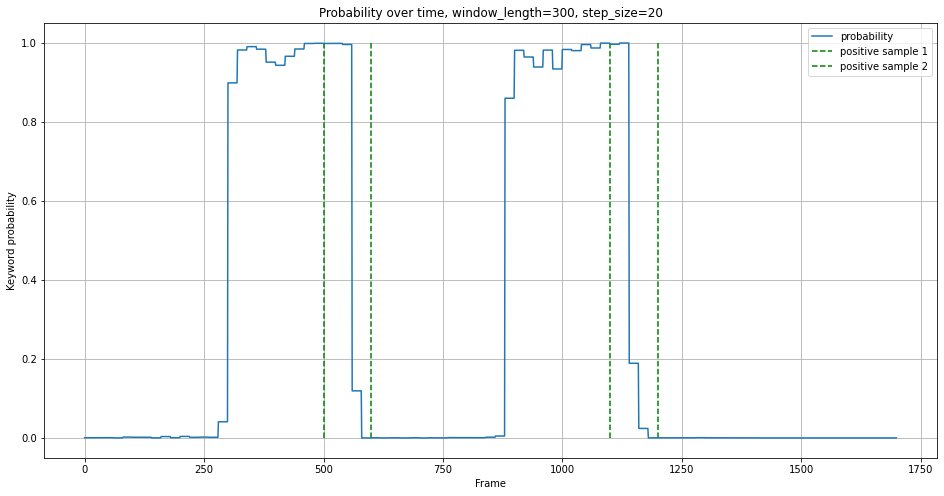

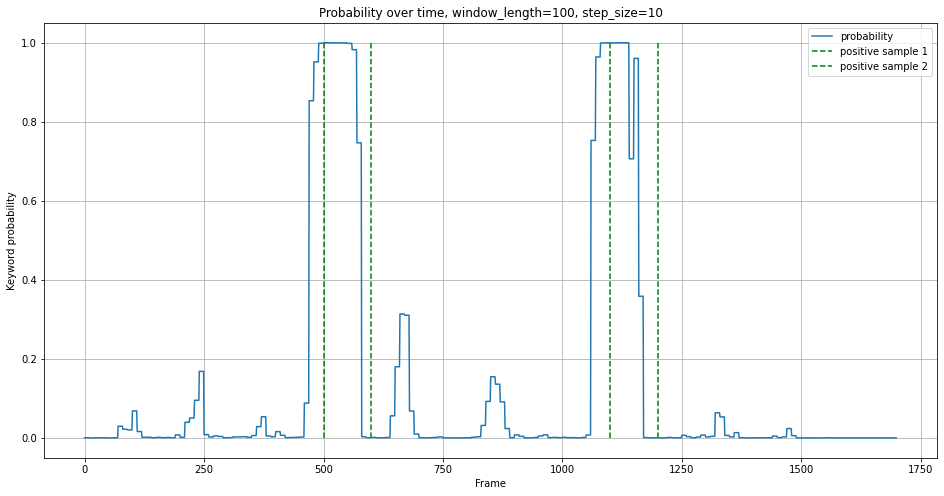

In [30]:
plot_streaming_configs(stream_model, [300, 100], [20, 10])

Как можем наблюдать, step_size также делает небольшую регуляризацию, "сглаживая пики". Наблюдая графики сверху, мы видели, что основные выбросы, когда наша вероятность резко растёт -- приходится на небольшие пики размером в несколько фреймов, если `step_size=10`, то мы с большой вероятностью проскочим этот пик и именно поэтому эта регуляризация будет работать. Но кроме этого, его задача это ускорение стриминга, ведь при `step_size=10`, мы будем запускать нашу модель в 10 раз реже. Судя по графикам сверху `window_length=100` и `step_size=10` хорошо ведёт себя с базовой моделью, его мы и сохраним в `jit` формат, пока не начали сжимать нашу модель.

In [31]:
stream_model.reset()
stream_script = torch.jit.script(stream_model)
stream_script.save('models/kws_baseline_model.pth')

## Speed up & Compression

Начнём оптимизацию нашей модели с того, что напишем пару вспомогательных функций, которые будут замерять память и также FLOPs наших моделей.

In [32]:
import tempfile

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

In [33]:
try:
    from thop import profile
except:
    %pip install thop
    from thop import profile

@torch.no_grad()
def calc_flops_and_size(model, melspec=melspec_train, device=config.device):
    model = deepcopy(model).eval()
    try:
        model.gru.flatten_parameters()
    except:
        pass
    sample_inp = melspec(torch.randn(1, 32_000).to(device))
    
    size = get_size_in_megabytes(model)
    macs, params = profile(model, (sample_inp, ), verbose=False)

    return 2 * macs, size, int(params)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Теперь сохраним базовые характеристики бейзлайна и на их основе будем проводить эксперименты

In [34]:
flops, size, params = calc_flops_and_size(model)
print(f'baseline model: KFLOPs={round(flops/1e3, 2)}, size={round(size * 2**10, 2)}KB, params={params}')

baseline model: KFLOPs=1809.22, size=102.51KB, params=25387


### Distilation

**Settings 1.**

Начнём с дистиляции, это должен быть основным нашим методом, который поможет улучшить `speed_up_rate` и значительную часть компрессии, оставшиеся методы, например, такие как квантизация будут влиять только на компрессию.

Начать дистиляцию нужно с подбора конфига, их мы можем подобрать великое множество, но всё же хочется, чтобы он удовлетворял некоторым критериям, а именно выбивал заданный скор по FLOPs и памяти. Снизу я привёл 1 из вариантов, как я искал нужные конфиги, какие-то гиперпараметры начали устаканиваться после множества экспериментов с параметрами "на рандом".

In [ ]:
max_param = 0
for k_1 in tqdm(range(3, 5+1)):
    for k_2 in range(3, 20+1):
        for s_1 in range(1, k_1):
            for s_2 in range(1, k_2):
                for hidden in range(7, 14):
                    student_config = TaskConfig(cnn_out_channels=3, kernel_size=(k_1, k_2), stride=(s_1, s_2), hidden_size=hidden, gru_num_layers=2, n_mels=40)
                    student = CRNN(student_config).to(student_config.device)
                    student_flops, student_size, student_params = calc_flops_and_size(student)
                    if min(flops/student_flops, 10) + min(size/student_size, 10) >= 19 and flops/student_flops <= 10.5 and size/student_size <= 10.5:
                        if student_params >= max_param:
                            max_param = student_params
                            best_fl = flops/student_flops
                            best_config = (k_1, k_2, s_1, s_2, hidden, best_fl, max_param, size/student_size)
                        print(k_1, k_2, s_1, s_2, hidden, student_params, min(flops/student_flops, 10) + min(size/student_size, 10), flops/student_flops, size/student_size)
print(best_config, best_fl, max_param)

Теперь нужно написать код, для обучения эпохи студента.
В данном случае использовалась дистиляция лишь на основе последнего слоя, она мне кажется самой логичной, ведь большой бейзлайн обучался не очень долго и мог найти не самые лучшие представления эмбедингов и если делать обучение по слоям, то это может очень сильно регуляризовать нашего студента и он не обучится, а при обучении по последнему слою, он может сам найти более выгодное и сжатое представление эмбедингов.

Лосс также очень важен и его я пербирал очень много раз, например, я тестировал loss на основе взвешенной суммы между лосами от учителя и лосами от исходной задачи, так же я эксперементировал с лосами между студентом и учителем, например, какое-то время я обучал модели используя KL дивергенцию между распределениями выходов учителя и студента, но в итоге я пришёл к лоссу, который работал лучше всего - это cross_entropy между логитами с студента с температурой T и вероятностями с температурой классов от учителя.

Температура подбиралась среди множества экспериментов и по итогу я оставил значение равным 7, оно мне показалось адекватным.

Такой loss стабилизировал обучение модели и со временем она медленно, но очень уверенно сходилась к хорошему скору, пусть на это и требовалось очень много эпох.

In [35]:
def train_student_epoch(model, teacher, opt, loader, log_melspec, device, T=1.0, alpha=1.0):
    progress_bar = tqdm(enumerate(loader), total=len(loader))
    model.train()
    teacher.eval()
    log_loss, log_acc = 0, 0
    for i, (batch, labels) in progress_bar:
        batch, labels = batch.to(device), labels.to(device)
        # t_batch = melspec_train(batch)
        batch = log_melspec(batch)

        opt.zero_grad()

        logits = model(batch)
        with torch.no_grad():
            t_logits = teacher(batch)

        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits / T, F.softmax(t_logits / T, dim=-1))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

        log_loss = (log_loss * i + loss.item()) / (i + 1)
        log_acc = (log_acc * i + acc) / (i + 1)
        if i % 10 == 0:
            progress_bar.set_description("Loss = {:.4f}, accuracy = {:.4f}".format(log_loss, log_acc))

    return acc

Наконец нужно инициализировать студента, одним из плюсов дистиляции является то, что мы перед его обучением можем измерить характеристики студента и понять, подходит ли он нам или нет. Снизу приведён конфиг одного из последних обученных мной студента.

In [36]:
set_seed()
student_config = TaskConfig(cnn_out_channels=3, kernel_size=(5, 12), stride=(4, 6), hidden_size=7, gru_num_layers=2, n_mels=40, num_epochs=200)
student = CRNN(student_config).to(student_config.device)
melspec_student_train = LogMelspec(is_train=True, config=student_config)
melspec_student_val = LogMelspec(is_train=False, config=student_config)

student_opt = torch.optim.Adam(
    student.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)

In [37]:
student_flops, student_size, student_params = calc_flops_and_size(student, melspec_student_train)
print(f'speed up rate={round(flops/student_flops, 5)}, compression rate={round(size/student_size, 2)}, student params={student_params}')

speed up rate=9.86207, compression rate=11.54, student params=1355


Как видим, такой студент работает почти в 10 раз быстрее и его компрессия 11.5 из-за малого количества параметров, это была одной из самых тяжёлых моделей для обучения в силу огромной регуляризации параметров и его так и не удалось обучить :(

Остальные конфиги, которые удалось обучить, в зависимости от их сложности, обучались от 20, вплоть до 150 эпох.

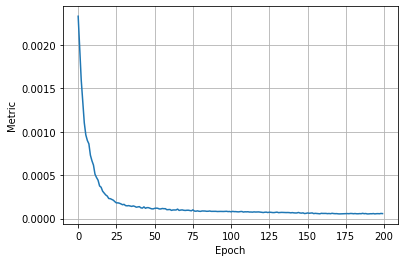

END OF EPOCH 199 LAST METRIC 5.7879243989299596e-05


In [ ]:
history_student = defaultdict(list)
for n in range(student_config.num_epochs):

    train_student_epoch(student, model, student_opt, train_loader,
                melspec_student_train, config.device, T=7, alpha=10)

    au_fa_fr = validation(student, val_loader,
                          melspec_student_val, config.device)
    history_student['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history_student['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    if au_fa_fr < 5.5e-5 and au_fa_fr == min(history_student['val_metric']):
        torch.save(student.state_dict(), f'models/student_{round(flops/student_flops, 3)}_{round(size/student_size, 2)}_{n}.pth')

    print('END OF EPOCH', n, 'LAST METRIC', history_student['val_metric'][-1])

Загрузим этот чекпоинт, проверим его скор, а также запустим для него стриминговую модель, чтобы убедиться, что он в целом работает.

In [38]:
student.load_state_dict(torch.load('checkpoints/student_9.862_11.54.pth'), strict=False)
validation(student, val_loader, melspec_student_val, config.device)

102it [00:05, 17.98it/s]


5.856849573491915e-05

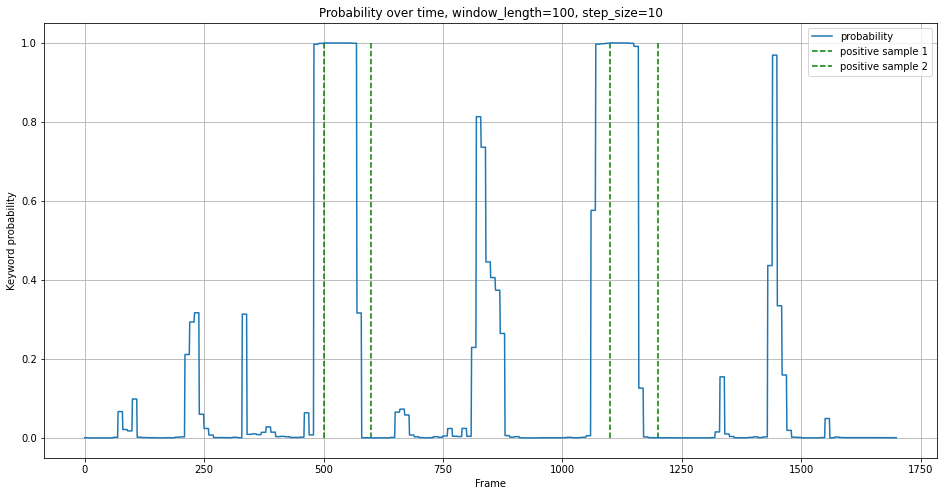

In [39]:
stream_distil_model = StreamingCRNN(student, student_config).eval()
plot_streaming_configs(stream_distil_model, [100], [10])

Осталось загрузить все перспективные конфиги, которые я обучал и построить для них графики:

In [40]:
all_distil_configs = [
    (TaskConfig(hidden_size=32),                                                          'checkpoints/baseline.pth',            'baseline'),
    (TaskConfig(cnn_out_channels=3, kernel_size=(5, 12), stride=(4, 6), hidden_size=7),   'checkpoints/student_9.862_11.54.pth', 'student_3_(5, 12)_(4, 6)_7'),
    (TaskConfig(cnn_out_channels=3, kernel_size=(5, 13), stride=(4, 8), hidden_size=9),   'checkpoints/student_10.654_9.36.pth', 'student_3_(5, 13)_(4, 8)_9'),
    (TaskConfig(cnn_out_channels=3, kernel_size=(3, 14), stride=(2, 13), hidden_size=11), 'checkpoints/student_10.428_6.12.pth', 'student_3_(3, 14)_(2, 13)_11'),
    (TaskConfig(cnn_out_channels=3, kernel_size=(3, 14), stride=(2, 13), hidden_size=12), 'checkpoints/student_9.709_5.58.pth',  'student_3_(3, 14)_(2, 13)_12'),
    (TaskConfig(cnn_out_channels=3, kernel_size=(3, 14), stride=(2, 13), hidden_size=13), 'checkpoints/student_9.055_5.11.pth',  'student_3_(3, 14)_(2, 13)_13'),
    (TaskConfig(cnn_out_channels=3, kernel_size=(3, 14), stride=(2, 13), hidden_size=15), 'checkpoints/student_7.918_4.31.pth',  'student_3_(3, 14)_(2, 13)_15'),
]

metrics = {'name': [], 'speed_up_rate': [], 'compression_rate': [], 'metrics': [], 'hw_score': []}
for stud_conf, weight, name in tqdm(all_distil_configs):
    student = CRNN(stud_conf).to(stud_conf.device)
    student.load_state_dict(torch.load(weight))
    student_flops, student_size, student_params = calc_flops_and_size(student, melspec_student_train)
    metrics['speed_up_rate'].append(flops/student_flops)
    metrics['metrics'].append(validation(student, val_loader, melspec_student_val, stud_conf.device))
    metrics['compression_rate'].append(size/student_size)
    metrics['name'].append(name)
    metrics['hw_score'].append((min(metrics['compression_rate'][-1], 10) + min(metrics['speed_up_rate'][-1], 10)) / 10 * 3.5 + 3)
    clear_output()

100%|██████████| 7/7 [01:08<00:00,  9.85s/it]


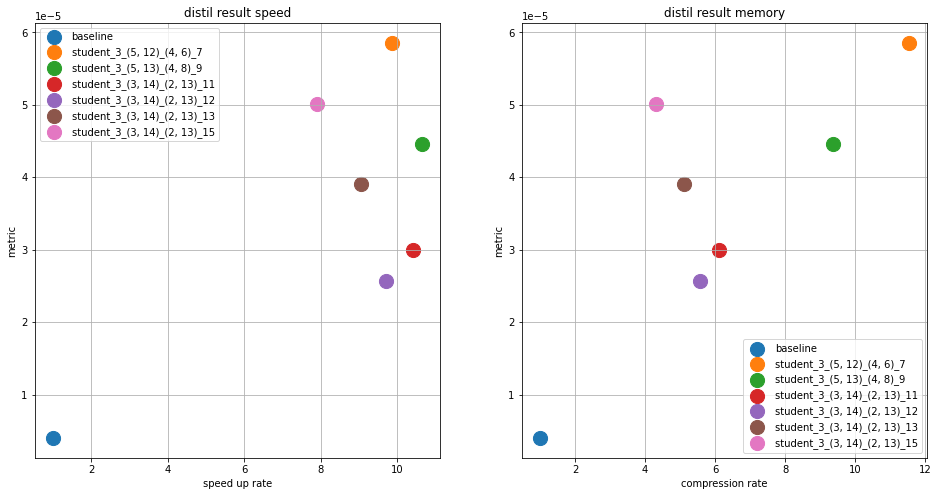

In [41]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 8))

for i in range(len(all_distil_configs)):
    axs[0].scatter([metrics['speed_up_rate'][i]], [metrics['metrics'][i]], label=metrics['name'][i], s=200)
    axs[1].scatter([metrics['compression_rate'][i]], [metrics['metrics'][i]], label=metrics['name'][i], s=200)

x_labels, titles = ['speed up rate', 'compression rate'], ['distil result speed', 'distil result memory']
for i, data in enumerate(zip(x_labels, titles)):
    axs[i].set_xlabel(data[0])
    axs[i].set_ylabel('metric')
    axs[i].set_title(data[1])
    axs[i].grid()
    axs[i].legend()

plt.show()

In [42]:
pd.DataFrame.from_dict(metrics)

,name,speed_up_rate,compression_rate,metrics,hw_score
0,baseline,1.000000,1.000000,0.000004,3.700000
1,"student_3_(5, 12)_(4, 6)_7",9.862067,11.536542,0.000059,9.951724
2,"student_3_(5, 13)_(4, 8)_9",10.654229,9.363215,0.000045,9.777125
3,"student_3_(3, 14)_(2, 13)_11",10.427518,6.116122,0.000030,8.640643
4,"student_3_(3, 14)_(2, 13)_12",9.708803,5.575556,0.000026,8.349526
5,"student_3_(3, 14)_(2, 13)_13",9.055498,5.106835,0.000039,7.956817
6,"student_3_(3, 14)_(2, 13)_15",7.918487,4.314290,0.000050,7.281472


Как видим, такой способ дистиляции помог обучить множество хороших моделей, пока самая лучшая получилась со `speed_up_rate` равным 9.86 и сжатием 11.5, но к сожалению у неё не получилось выбить нужный скор, но есть ещё некоторые хорошие модели, которые обучились значительно лучше с нужным скором, а также со `speed_up_rate` равным 10+ и сжатием от 6 до 9 их можно попробовать дожать с помощью квантизации, займёмся этим дальше.

### Quantization

**Settings 2.**

Начнём квантизировать бейзлайн и посмотрим, как он влияет на нашу модель.

In [43]:
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

In [44]:
def quantize_model(model, dtype=torch.qint8):
    model = deepcopy(model).eval().cpu()
    quant_model = torch.quantization.quantize_dynamic(model, {nn.GRU, nn.Linear, nn.Conv2d}, dtype=dtype)
    return quant_model

In [45]:
model_int8 = quantize_model(model)

quant_melspec_val = deepcopy(melspec_val)
quant_melspec_val.melspec.to('cpu')

quant_flops, quant_size, quant_params = calc_flops_and_size(model_int8, quant_melspec_val, 'cpu')
print(f'speed up rate={round(flops/quant_flops, 2)}, compression rate={round(size/quant_size, 2)}, student params={quant_params}')

speed up rate=2.73, compression rate=2.88, student params=808


In [46]:
validation(model, val_loader, melspec_val, config.device)

102it [00:05, 18.25it/s]


3.992289331770433e-06

In [47]:
validation(model_int8, val_loader, quant_melspec_val, 'cpu')

102it [00:08, 11.64it/s]


4.153413116460719e-06

Как можем наблюдать, компрессия бейзлайна при int8 квантизации улучшилась почти в 3 раза, при этом мы почти не потеряли в качестве.

### Distilation + Quant

**Settings 3.**

Теперь попробуем объединить дистиляцию и квантизацию, сначала мы попробуем взять конфиг по скорости на 10 и компрессией на 6 и будем надеяться, что сможем сжать его хотя бы в 2 раза:

In [48]:
quant_config = TaskConfig(cnn_out_channels=3, kernel_size=(3, 14), stride=(2, 13), hidden_size=11)
quant_student = CRNN(quant_config).to(quant_config.device)
quant_student.load_state_dict(torch.load('checkpoints/student_10.428_6.12.pth'))
quant_flops, quant_size, quant_params = calc_flops_and_size(quant_student, melspec_student_train)
print(f'speed up rate={round(flops/quant_flops, 5)}, compression rate={round(size/quant_size, 2)}, student params={quant_params}')

speed up rate=10.42752, compression rate=6.12, student params=3399


In [49]:
validation(quant_student, val_loader, melspec_val, config.device)

102it [00:05, 18.03it/s]


2.9957088857231043e-05

In [50]:
quant_student_int8 = quantize_model(quant_student)
quant_flops, quant_size, quant_params = calc_flops_and_size(quant_student_int8, quant_melspec_val, 'cpu')
print(f'speed up rate={round(flops/quant_flops, 2)}, compression rate={round(size/quant_size, 2)}, student params={quant_params}')

speed up rate=25.19, compression rate=8.98, student params=129


In [51]:
validation(quant_student_int8, val_loader, quant_melspec_val, 'cpu')

102it [00:08, 12.20it/s]


3.0154017927408062e-05

Как видим, модель всё ещё работает с хорошим скором, но компрессия увеличилась не очень сильно, мы смогли добить её лишь до 9, поэтому протестируем другую модель, со скоростью 10+ и компрессией на 9:

In [52]:
quant_config = TaskConfig(cnn_out_channels=3, kernel_size=(5, 13), stride=(4, 8), hidden_size=9)
quant_student = CRNN(quant_config).to(quant_config.device)
quant_student.load_state_dict(torch.load('checkpoints/student_10.654_9.36.pth'))
quant_flops, quant_size, quant_params = calc_flops_and_size(quant_student, melspec_student_train)
print(f'speed up rate={round(flops/quant_flops, 5)}, compression rate={round(size/quant_size, 2)}, student params={quant_params}')

speed up rate=10.65423, compression rate=9.36, student params=1884


In [53]:
validation(quant_student, val_loader, melspec_val, config.device)

102it [00:05, 18.12it/s]


4.4601450621303755e-05

In [54]:
quant_student_int8 = quantize_model(quant_student)
quant_flops, quant_size, quant_params = calc_flops_and_size(quant_student_int8, quant_melspec_val, 'cpu')
print(f'speed up rate={round(flops/quant_flops, 2)}, compression rate={round(size/quant_size, 2)}, student params={quant_params}')

speed up rate=21.48, compression rate=10.28, student params=198


In [55]:
validation(quant_student_int8, val_loader, quant_melspec_val, 'cpu')

102it [00:08, 12.54it/s]


4.416581964788187e-05

И наконец, такой конфиг смог нам пробить заветный скор по компрессии на 10 баллов и скоростью на 10. При этом всём, качество даже немного выросло.

Также ради эксперимента посмотрим, как себя ведёт квантизация во fp16:

In [56]:
quant_student_fp16 = quantize_model(quant_student, torch.float16)
quant_flops, quant_size, quant_params = calc_flops_and_size(quant_student_fp16, quant_melspec_val, 'cpu')
print(f'speed up rate={round(flops/quant_flops, 2)}, compression rate={round(size/quant_size, 2)}, student params={quant_params}')

speed up rate=21.48, compression rate=7.08, student params=198


In [57]:
validation(quant_student_fp16, val_loader, quant_melspec_val, 'cpu')

102it [00:08, 12.44it/s]


4.4619353264047125e-05

### Distilation + manual Quant

**Settings 3.1**

Также стало интересно, почему квантизация не уменьшает размер нашей модели в 2 раза, если мы можем хранить все веса в fp16 и которые будут весить в 2 раза меньше оригинала, для этого я хотел протестировать небольшой костыль, который руками переведёт все веса в fp16:

In [58]:
quant_config = TaskConfig(cnn_out_channels=3, kernel_size=(5, 13), stride=(4, 8), hidden_size=9)
quant_student = CRNN(quant_config).to(quant_config.device)
quant_student.load_state_dict(torch.load('checkpoints/student_10.654_9.36.pth'))
quant_flops, quant_size, quant_params = calc_flops_and_size(quant_student, melspec_student_train)
print(f'speed up rate={round(flops/quant_flops, 5)}, compression rate={round(size/quant_size, 2)}, student params={quant_params}')

speed up rate=10.65423, compression rate=9.36, student params=1884


In [59]:
validation(quant_student, val_loader, melspec_val, config.device)

102it [00:05, 17.48it/s]


4.4601450621303755e-05

Для этого я написал небольшую обёртку над CRNN, который переводит все веса в fp16 и при этом переводит input и output в нужные нам форматы

In [60]:
class FP16_model(CRNN):
    def __init__(self, config, model):
        super().__init__(config)
        
        self.load_state_dict(model.state_dict())
        for param in self.parameters():
            param.data = param.data.to(torch.float16)
        self.gru.flatten_parameters()
        self.to(config.device)
        
    def forward(self, input):
        input = input.to(torch.float16)
        output = super().forward(input)
        return output.to(torch.float32)

In [61]:
fp16_student = FP16_model(quant_config, quant_student)

In [62]:
quant_flops, quant_size, quant_params = calc_flops_and_size(fp16_student, melspec_student_train)
print(f'speed up rate={round(flops/quant_flops, 5)}, compression rate={round(size/quant_size, 2)}, student params={quant_params}')

speed up rate=10.65423, compression rate=14.12, student params=1884


In [63]:
validation(fp16_student, val_loader, melspec_val, config.device)

102it [00:05, 17.91it/s]


4.4625320811628247e-05

Как мы видим, этот метод даже работает и увеличил нам компрессию пусть не в 2 раза, но очень значительно. И при этом мы даже почти не упали в качестве. Единственный нюанс, так это то, что он не будет работать на cpu, потому что свёртки на cpu не умеют работать в half формате, поэтому не будем его использовать как финальный.

### Pruning

**Settings 4.**

Здесь я пытался разобраться с торчёвым прунингом, но он так у меня и не завёлся, снизу остался какой-то небольшой шаблон, но по итогу мне так и не получилось скомпресовать мою модель и перевести её в sparse формат...

In [64]:
prune_model = CRNN(config).to(config.device)
prune_model.load_state_dict(torch.load('checkpoints/baseline.pth'))
prune_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

In [65]:
import torch.nn.utils.prune as prune

parameters_to_prune = (
    (prune_model.conv[0], 'weight'),
    (prune_model.attention.energy[0], 'weight'),
    (prune_model.attention.energy[2], 'weight'),
    (prune_model.classifier, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.95,
)

## Final Model

Пришло время финальной модели, будем работать с конфигом Distil + int8, который смог нам выбить ровно 10 баллов, загрузим его и убедимся, что он выбивает нам нужный скор:

In [66]:
final_config = TaskConfig(cnn_out_channels=3, kernel_size=(5, 13), stride=(4, 8), hidden_size=9)
final_model = CRNN(final_config).to(final_config.device)
final_model.load_state_dict(torch.load('checkpoints/student_10.654_9.36.pth'))
final_flops, final_size, final_params = calc_flops_and_size(final_model, melspec_student_train)
print(f'speed up rate={round(flops/final_flops, 3)}, compression rate={round(size/final_size, 3)}, student params={final_params}')

speed up rate=10.654, compression rate=9.363, student params=1884


In [67]:
final_int8 = quantize_model(final_model)
final_flops, final_size, final_params = calc_flops_and_size(final_int8, quant_melspec_val, 'cpu')
print(f'speed up rate={round(flops/final_flops, 2)}, compression rate={round(size/final_size, 2)}, student params={final_params}')

speed up rate=21.48, compression rate=10.28, student params=198


In [68]:
validation(final_int8, val_loader, quant_melspec_val, 'cpu')

102it [00:08, 11.58it/s]


4.416581964788187e-05

Теперь же создадим стриминг на его основе и попробуем поподбирать гиперпараметры.

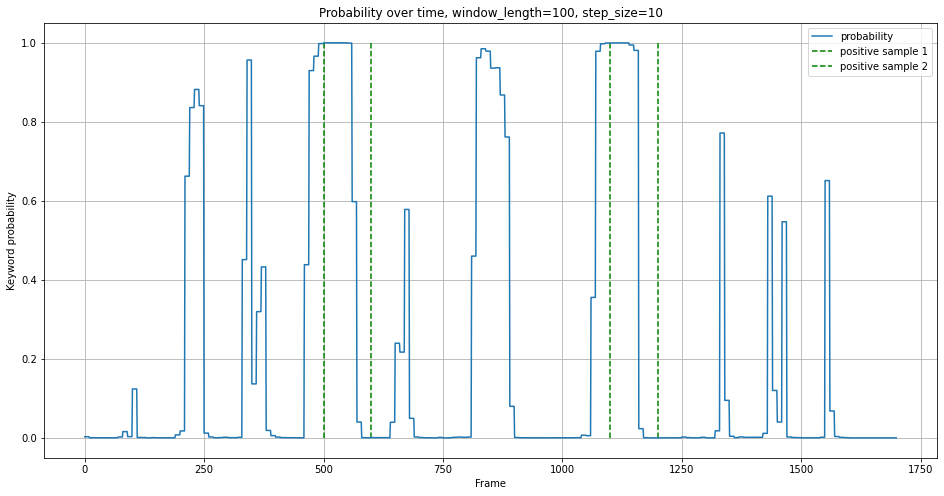

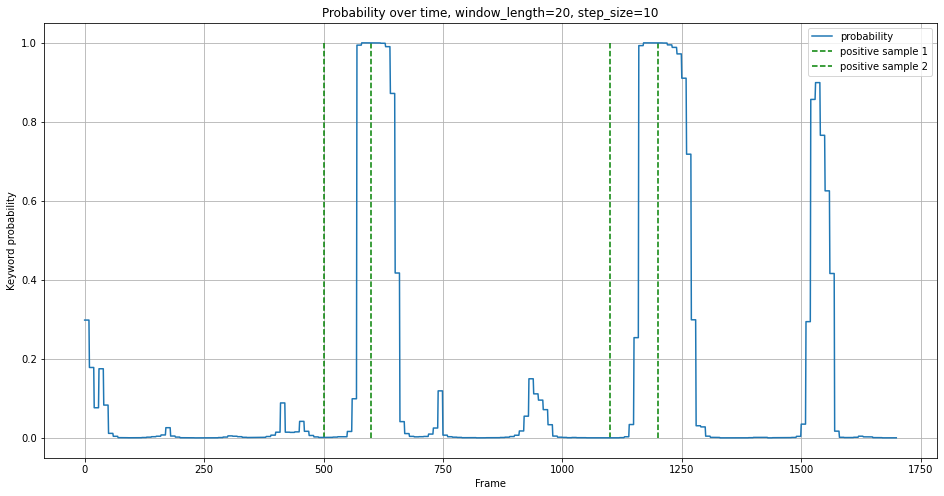

In [69]:
stream_final = StreamingCRNN(final_int8, final_config).eval()
plot_streaming_configs(stream_final, [100, 20], [10, 10])

Как мы видим, в данном случае, модель значительно лучше себя ведёт с небольшим окном, по сравнению с бейзлайном, поэтому будем использовать его именно в такой конфигурации.

Но всё ещё есть некоторая проблема, которую я заметил при тестировании и которую видно на гафиках - у нас часто бывают FP пики, но при этом все TP пики по скору очень близки к 1, поэтому, чтобы уменьшить FP и не испортить TP - хочется поднять уровень key word.

К счастью у нас есть весь необходимый код для тестирования, в этот раз соберём 132 записи в случайном порядке из позитивных и отрицательных примеров и попробуем по ним глазами подобрать хороший порог.

In [70]:
set_seed(42)
stream_melspec = LogMelspec(is_train=False, config=TaskConfig)
stream_melspec.melspec.cpu()

positive = np.random.choice(val_set.csv[val_set.csv.label == 1].index.values, size=12, replace=False)
negative = np.random.choice(val_set.csv[val_set.csv.label == 0].index.values, size=120, replace=False)

samples = np.append(positive, negative)[np.random.permutation(len(negative) + len(positive))].tolist()

sample_wavs = []
sample_labels = []
sample_idx = []
glob_len = 0

for idx in samples:
    wav = val_set[idx]['wav'].view(1, -1)
    label = val_set[idx]['label']
    len_wav = stream_melspec(wav).size(-1) - 1

    sample_wavs.append(wav)
    sample_labels.append(label)
    sample_idx.append([glob_len, glob_len + len_wav])
    glob_len += len_wav

cat_wav = torch.cat(sample_wavs, dim=-1)

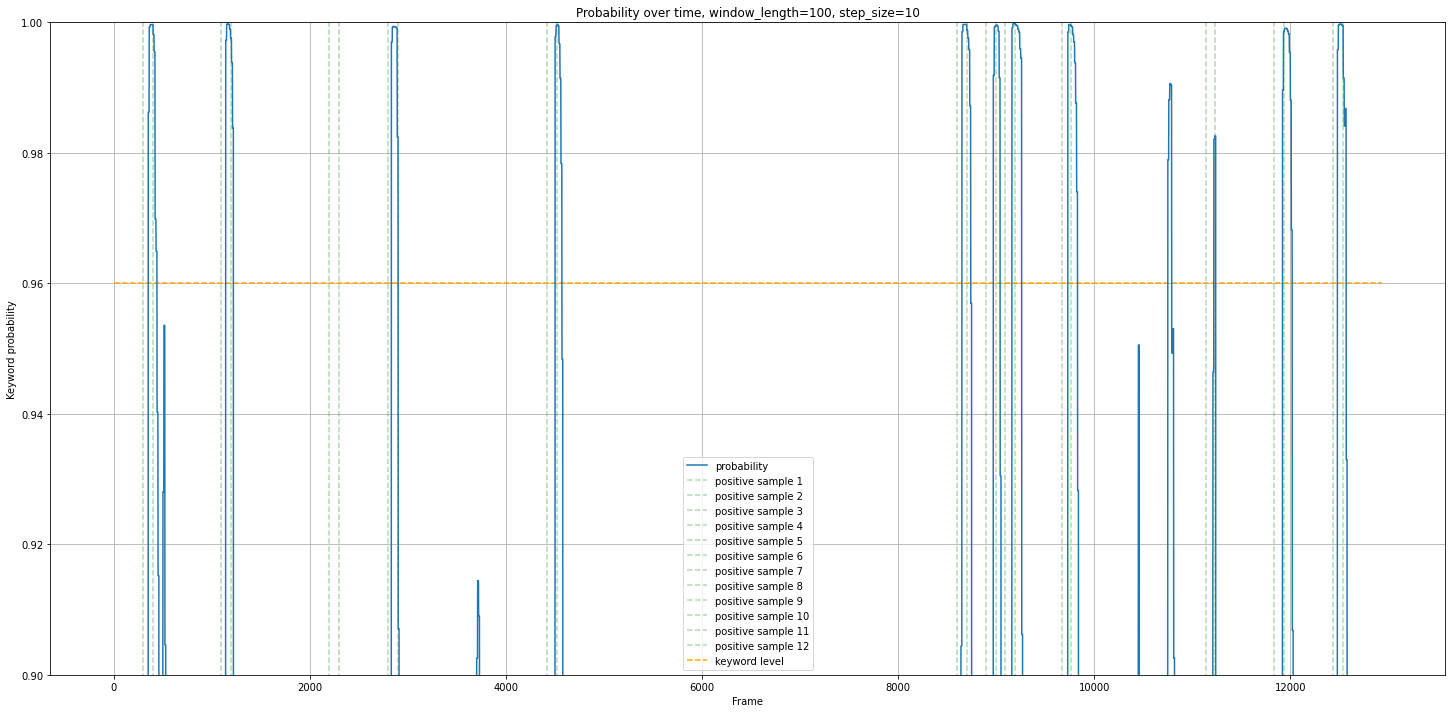

In [75]:
stream_final.reset()
stream_final.set_max_window_length(20)
stream_final.set_streaming_step_size(10)

with torch.inference_mode():
    predict = stream_final(cat_wav, reduce=False)

# We do processing for each frame
predict = predict.view(-1, 1).expand(-1, 10).reshape(-1)
pad = torch.Tensor([predict[-1]] * (glob_len - predict.shape[0]))
predict = torch.cat((predict, pad))

fig, ax = plt.subplots(figsize=(25, 12))
ax.plot(predict, label='probability')
ax.set_title(f'Probability over time, window_length={100}, step_size={10}')
ax.set_xlabel('Frame')
ax.set_ylabel('Keyword probability')

pos_cnt = 0
for i in range(len(sample_labels)):
    if sample_labels[i]:
        pos_cnt += 1
        start, end = sample_idx[i]
        ax.vlines(start, 0, 1, color='green', linestyles='dashed', label=f'positive sample {pos_cnt}', alpha=0.3)
        ax.vlines(end, 0, 1, color='green', linestyles='dashed', alpha=0.3)
ax.hlines(0.96, 0, len(predict), color='orange', linestyles='dashed', label=f'keyword level')
ax.set_ylim(0.90, 1)

plt.legend()
plt.grid()
plt.show()

Как видим, если мы зададим уровень ключевого слова около 0.96, то на таком большом отрезке у нас будет всего-лишь 1 FP пример и будет 1 FN пример. И в целом при ручном тестировании, этот порог мне показался достаточно адекватным, его мы и будем использовать.

Сохраним нашу финальную стриминговую модель:

In [72]:
stream_final.reset()
stream_script = torch.jit.script(stream_final)
stream_script.save('models/kws_final_model.pth')